# DATA 695 Capstone Project

### Imad Ahmad (30198988) and Zakir Ullah ()

# Data Cleaning and Wrangling

## Loading Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

crimes = pd.read_csv('data/crime.csv')
education = pd.read_csv('data/education.csv')
population = pd.read_csv('data/population.csv')
visitors = pd.read_csv('data/visitors.csv')
census = pd.read_csv('data/population factors.csv')

## Cleaning and Combining the Datasets

In [2]:
# Removing the year 2021 as this is not included in the other datasets
crimes = crimes.loc[crimes['REF_DATE'] != 2021]

# Remove unwanted columns. I kept the 'GEO', 'REF_DATE', and 'VALUE' columns.
crimes = crimes[['GEO', 'REF_DATE', 'VALUE']]

# Group by 'GEO' and 'REF_DATE'. Here I summed together the values for each province for each year.
crimes_grouped = crimes.groupby(['GEO', 'REF_DATE'])['VALUE'].sum().reset_index()

# Clean 'GEO' names. Remove the number in brackets at the end of each province name.
crimes_grouped['GEO'] = crimes_grouped['GEO'].str.replace('\s*\[\d+\]', '', regex=True)

# Filter out unwanted rows. I removed the rows that contained the following value in the 'GEO' column.
crimes_grouped = crimes_grouped.loc[crimes_grouped['GEO'] != 'Canadian Forces Military Police']

# Rename columns. I renamed the columns to 'Province', 'Year', and 'Crimes'.
crimes_grouped = crimes_grouped.rename(columns={'VALUE': 'Crimes', 'GEO': 'Province', 'REF_DATE': 'Year'})

# Group Territories. I grouped the territories together and summed the values for each year.
territories = ['Northwest Territories', 'Nunavut', 'Yukon']
total_territories_crimes = crimes_grouped[crimes_grouped['Province'].isin(territories)].groupby('Year')['Crimes'].sum().reset_index()
total_territories_crimes['Province'] = 'Territories'

# Remove Territories from crimes_grouped and add total_territories_crimes to crimes_grouped.
crimes_grouped = pd.concat([crimes_grouped, total_territories_crimes], ignore_index=True)
crimes_grouped = crimes_grouped[~crimes_grouped['Province'].isin(territories)]

# Group Territories for the Population dataset
total_territories_population = population[population['Province'].isin(territories)].groupby('Year')['Population'].sum().reset_index()
total_territories_population['Province'] = 'Territories'

# Remove individual Territories from the Population dataset and add the grouped data
population = pd.concat([population, total_territories_population], ignore_index=True)
population = population[~population['Province'].isin(territories)]

# Group Territories for the Education dataset
total_territories_visitors = visitors[visitors['Province'].isin(territories)].groupby('Year')['Visitors'].sum().reset_index()
total_territories_visitors['Province'] = 'Territories'

# Remove individual Territories from the Education dataset and add the grouped data
visitors = pd.concat([visitors, total_territories_visitors], ignore_index=True)
visitors = visitors[~visitors['Province'].isin(territories)]

# Merge the datasets together
merged_df = crimes_grouped.merge(education, on=['Province', 'Year'], how='outer')

merged_df_2 = merged_df.merge(population, on=['Province', 'Year'], how='outer')

merged_df_3 = merged_df_2.merge(visitors, on=['Province', 'Year'], how='outer')

final_merge = merged_df_3.merge(census, on=['Province', 'Year'], how='outer')

# Normalize numerical columns
cols_to_normalize = [
    'Crimes', 'Registrants', 'Visitors', 'Births', 'Deaths', 'Immigrants', 
    'Emigrants', 'Returning Emigrants', 'Net Temporary Migration', 
    'Net Interprovincial Migration', 'Net non-permanent residents'
]

for col in cols_to_normalize:
    final_merge[f'normalized {col}'] = final_merge[col] / final_merge['Population']

final_merge.drop(cols_to_normalize, axis=1, inplace=True)
final_merge.drop('Population', axis=1, inplace=True)

final_merge.head()

,Province,Year,normalized Crimes,normalized Registrants,normalized Visitors,normalized Births,normalized Deaths,normalized Immigrants,normalized Emigrants,normalized Returning Emigrants,normalized Net Temporary Migration,normalized Net Interprovincial Migration,normalized Net non-permanent residents
0,Alberta,2017,0.236092,0.045562,0.520263,0.012443,0.006131,0.009088,0.001542,0.001174,0.000533,-0.000763,-0.000310
1,Alberta,2018,0.241617,0.046412,0.552580,0.012118,0.005964,0.009434,0.001522,0.001129,0.000533,-0.000471,0.000701
2,Alberta,2019,0.244361,0.046483,0.453584,0.011578,0.006186,0.008089,0.001068,0.000878,0.000476,-0.000542,0.000066
3,Alberta,2020,0.211207,0.046027,0.085557,0.011116,0.006846,0.005429,0.001128,0.000985,0.000354,-0.002139,-0.000937
4,British Columbia,2017,0.169127,0.057886,1.767273,0.008939,0.007692,0.008457,0.002218,0.001223,0.001081,0.002822,0.005911


# EDA

## Provincial Crime Comparison

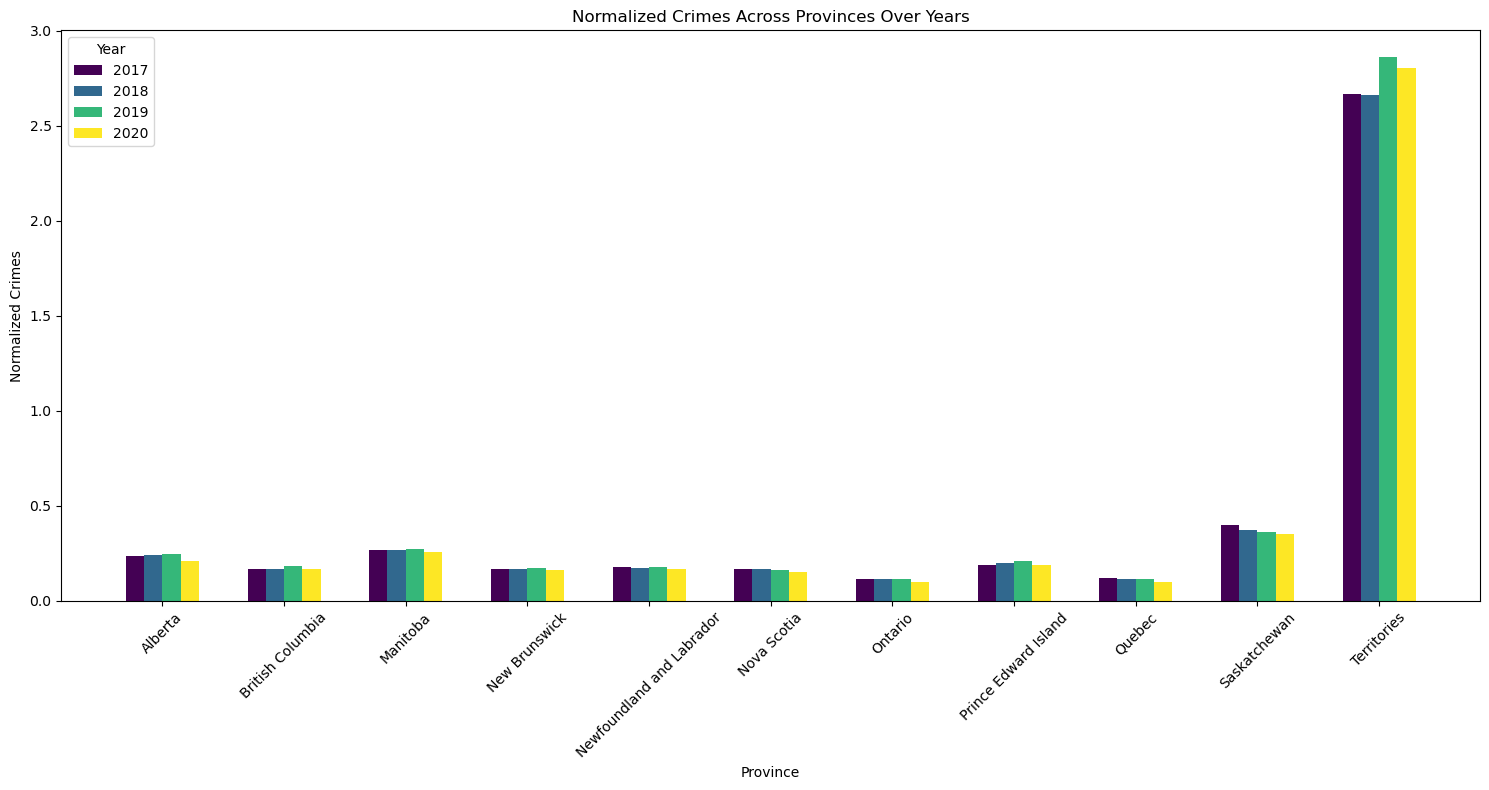

In [3]:
plt.figure(figsize=(15, 8))

years = final_merge['Year'].unique()
provinces = final_merge['Province'].unique()
n_years = len(years)
ind = np.arange(len(provinces))

for idx, year in enumerate(years):
    yearly_data = final_merge[final_merge['Year'] == year].sort_values(by='Province')
    plt.bar(ind + idx*0.15, yearly_data['normalized Crimes'], width=0.15, 
            label=str(year), color=plt.cm.viridis(np.linspace(0, 1, len(years)))[idx], align='center')

plt.xlabel('Province')
plt.ylabel('Normalized Crimes')
plt.title('Normalized Crimes Across Provinces Over Years')
plt.xticks(ind + 0.15*(n_years-1)/2, provinces, rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.savefig("images/crimes_across_provinces.png", dpi=300) 
plt.show()

## Correlations Between Crime and Other Variables

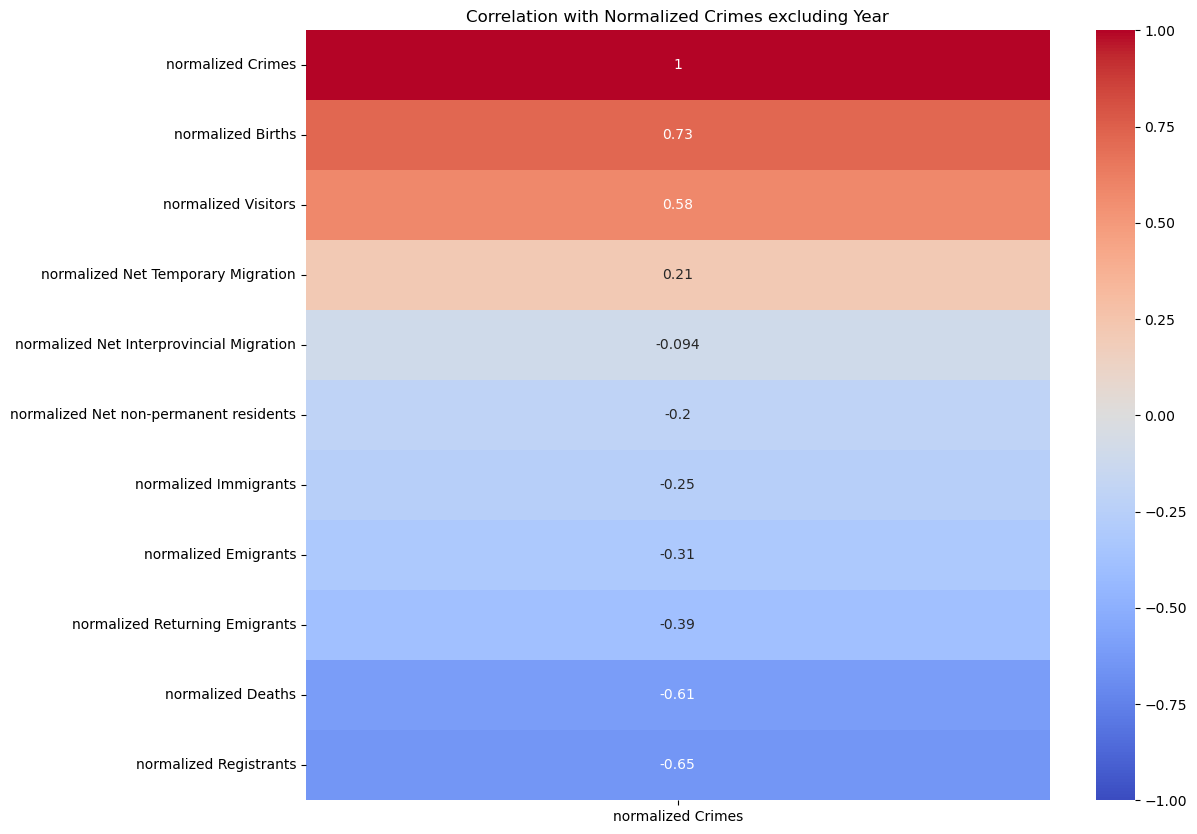

In [4]:
# Assuming your dataframe is named final_merge
numeric_cols = [col for col in final_merge.columns if final_merge[col].dtype in ['int64', 'float64']]
numeric_cols.remove('Year')
numeric_df = final_merge[numeric_cols]

correlations = numeric_df.corr()
crime_correlations = correlations[['normalized Crimes']]

plt.figure(figsize=(12, 10))
sns.heatmap(crime_correlations.sort_values(by="normalized Crimes", ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation with Normalized Crimes excluding Year")
plt.savefig("images/correlations_with_crime.png", dpi=300) 
plt.show()

# Machine Learning Models

## Feature Selection

### Encoding and Splitting Data

In [5]:
# One-hot encode the 'Province' column
final_merge_encoded = pd.get_dummies(final_merge, columns=['Province'])

X = final_merge_encoded.drop('normalized Crimes', axis=1)
y = final_merge_encoded['normalized Crimes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Ranking by Feature Importance

In [6]:
# Train a decision tree regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

# Get feature importances
feature_importances = dt_reg.feature_importances_

# Displaying feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                                     Feature    Importance
4                          normalized Deaths  9.925053e-01
3                          normalized Births  4.326860e-03
0                                       Year  1.034864e-03
1                     normalized Registrants  9.845877e-04
9   normalized Net Interprovincial Migration  9.011433e-04
6                       normalized Emigrants  9.771903e-05
8         normalized Net Temporary Migration  7.723450e-05
2                        normalized Visitors  4.844528e-05
10    normalized Net non-permanent residents  2.298719e-05
7             normalized Returning Emigrants  6.239608e-07
5                      normalized Immigrants  2.040755e-07
19                           Province_Quebec  1.165448e-09
16                      Province_Nova Scotia  0.000000e+00
20                     Province_Saskatchewan  0.000000e+00
18             Province_Prince Edward Island  0.000000e+00
17                          Province_Ontario  0.000000e+

### Recursive Feature Elimination

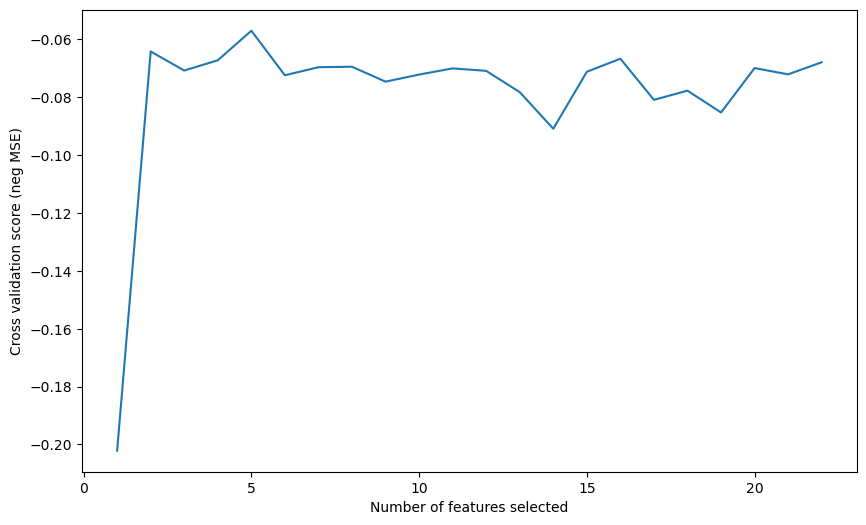

Optimal number of features:  5
Selected features:  Index(['normalized Registrants', 'normalized Visitors', 'normalized Births',
       'normalized Deaths', 'Province_Territories'],
      dtype='object')


In [7]:
# Initialize a random forest regressor
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize RFECV
selector = RFECV(estimator, step=1, cv=KFold(5), scoring='neg_mean_squared_error', n_jobs=-1)

selector = selector.fit(X_train, y_train)

# Plot number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MSE)")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.savefig("images/cross_val_tree.png", dpi=300) 
plt.show()


selected_features = X_train.columns[selector.support_]
print("Optimal number of features: ", selector.n_features_)
print("Selected features: ", selected_features)


### Checking for Multicollinearity

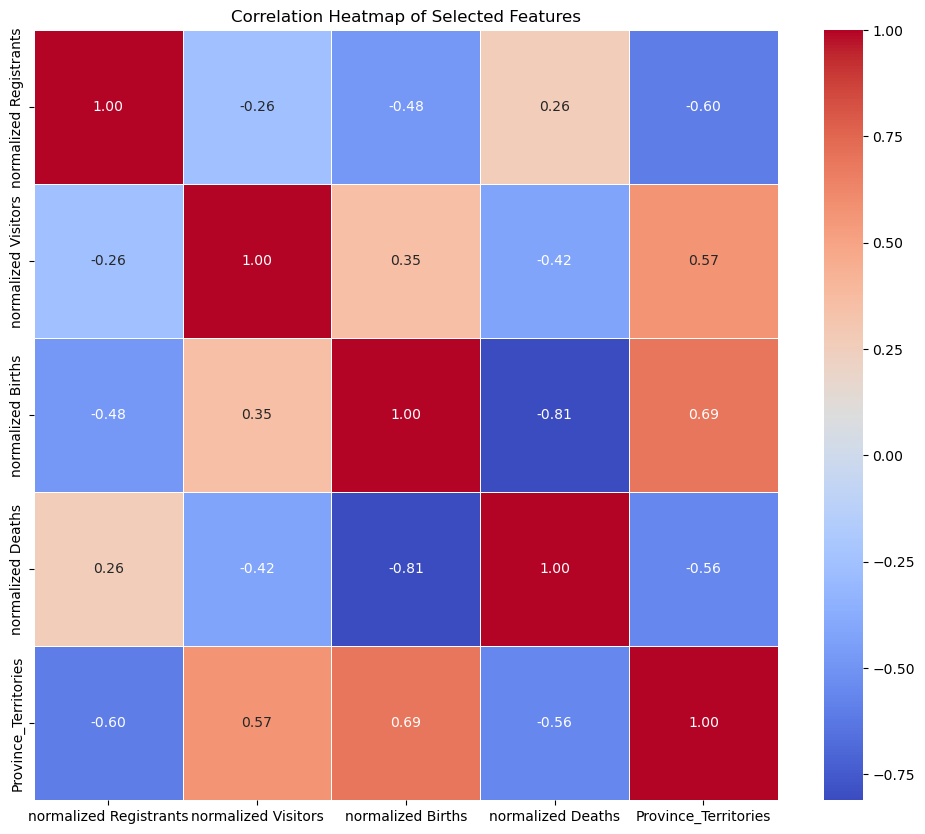

In [8]:
# One-hot encode the 'Province' column
final_merge_encoded = pd.get_dummies(final_merge, columns=['Province'])

X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of features you are interested in:
selected_features = ['normalized Registrants', 'normalized Visitors', 'normalized Births', 
                     'normalized Deaths'] + [col for col in X_train.columns if 'Province_' in col]

# Reduce X_train based on selected features
X_train_reduced = X_train[selected_features]

# Calculate correlation matrix
corr_matrix = X_train_reduced.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.savefig("images/correlation_heatmap.png", dpi=300) 
plt.show()


In [9]:
X_train.drop(['normalized Births'], axis=1)
X_test.drop(['normalized Births'], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Regression Tree Model

In [10]:
# Initialize the Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Train the regressor on the training data
dt_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = dt_reg.predict(X_test_scaled)

# Calculate and print the Mean Squared Error and the R^2 Value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Value: {r2}")


Mean Squared Error (MSE): 0.0001471554620526609
R^2 Value: 0.9997562593031135


### Max Depth Analysis

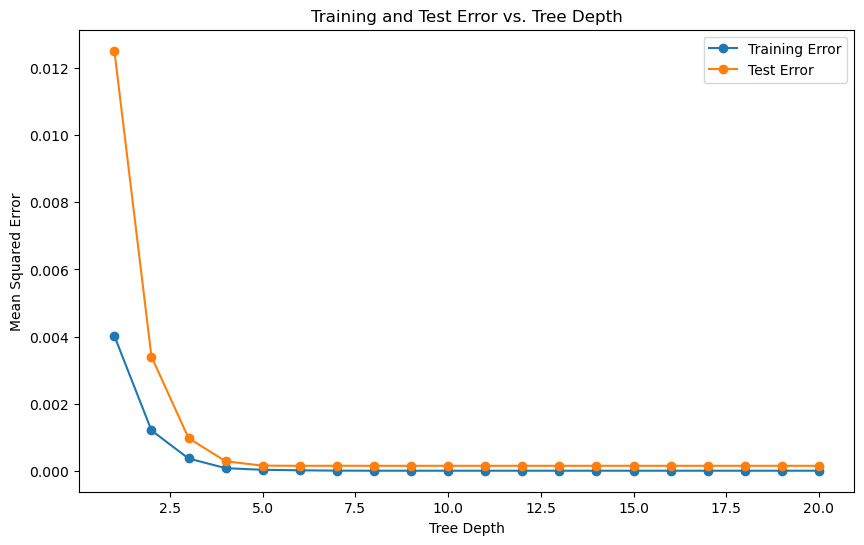

In [11]:
max_depths = range(1, 21)  # Assuming we test up to depth of 20
train_errors = []
test_errors = []

for max_depth in max_depths:
    dt_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    dt_reg.fit(X_train_scaled, y_train)
    
    y_train_pred = dt_reg.predict(X_train_scaled)
    y_test_pred = dt_reg.predict(X_test_scaled)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', marker='o')
plt.plot(max_depths, test_errors, label='Test Error', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Test Error vs. Tree Depth')
plt.savefig("images/tree_depth_analysis.png", dpi=300) 
plt.show()

### Learning Curve Analysis

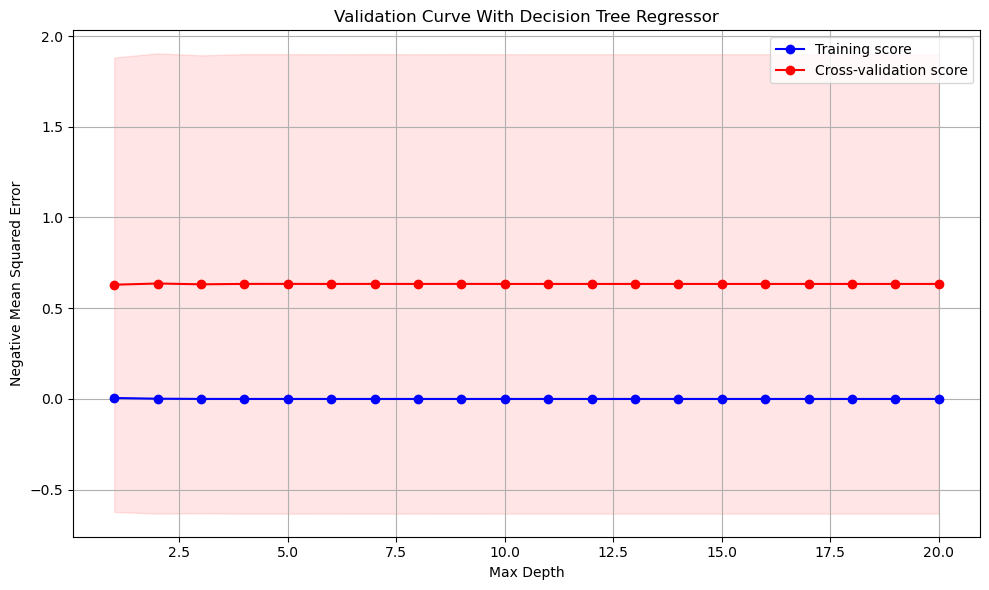

In [12]:
from sklearn.model_selection import validation_curve

# Set the range of values for the hyperparameter (in this case, max_depth)
param_range = range(1, 21)  # Checking depths from 1 to 20

# Calculate accuracy on training and test sets using validation curve
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state=42), 
    X, y, 
    param_name="max_depth", 
    param_range=param_range,
    cv=5, 
    scoring="neg_mean_squared_error"
)

# Calculate mean and standard deviation for training set scores
train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = -np.mean(test_scores, axis=1)
test_std = -np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker='o')
plt.plot(param_range, test_mean, label="Cross-validation score", color="red", marker='o')

# Create bands for the standard deviations
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.1)

# Create plot
plt.title("Validation Curve With Decision Tree Regressor")
plt.xlabel("Max Depth")
plt.ylabel("Negative Mean Squared Error")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.savefig("images/learning_curve.png", dpi=300) 
plt.show()


## Lasso Regression Model

### Alpha Hyperparameter Tuning

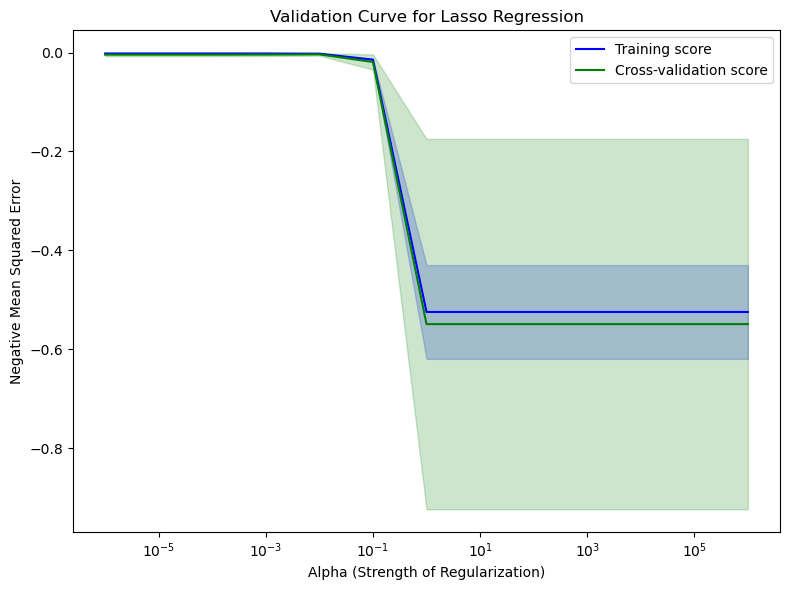

The ideal value for alpha is: 0.01


In [13]:
# Define a range of alpha values
param_range = np.logspace(-6, 6, 13)

# Compute train and test scores for each alpha using `validation_curve`
train_scores, test_scores = validation_curve(
    Lasso(),
    X_train_scaled,
    y_train,
    param_name="alpha",
    param_range=param_range,
    scoring="neg_mean_squared_error", # assuming you are interested in MSE
    cv=5
)

# Calculate mean and standard deviation for training and test sets
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 6))
plt.semilogx(param_range, train_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.semilogx(param_range, test_mean, label="Cross-validation score", color="green")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title("Validation Curve for Lasso Regression")
plt.xlabel("Alpha (Strength of Regularization)")
plt.ylabel("Negative Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("images/validation_lasso.png", dpi=300) 
plt.show()

# Index of the maximum validation score
ideal_index = np.argmax(test_mean)

# Corresponding alpha value
ideal_alpha = param_range[ideal_index]

print(f"The ideal value for alpha is: {ideal_alpha}")



## Final Model Results

In [14]:
# Initialize Lasso regression model
lasso_reg = Lasso(alpha=0.01)

# Fit the model to the training data
lasso_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso_reg.predict(X_test_scaled)

# Calculate and print the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Value: {r2}")

Mean Squared Error (MSE): 0.00612162363226048
R^2 Value: 0.9898604592083017
